### AIMS Machine Learning Assignment
##### Author: Francisco Girbal Eiras

The purpose of this assignment is to _"implement a neural network (NN) from scratch, without using the pre-implemented NN modules in popular machine learning frameworks such as PyTorch and TensorFlow, and train it to perform regression or classification with a small dataset of their choice"_. 

The implementation is provided in the `small-nn` package which we will now install in this notebook for the experiments that make up the report.

In [9]:
!pip install -e .

Obtaining file:///Users/fge/Dropbox/Oxford/AIMS/taught/michaelmas/machine_learning/labs/assignment/aims-ml-nn
  Attempting uninstall: smallnn
    Found existing installation: smallnn 1.0
    Uninstalling smallnn-1.0:
      Successfully uninstalled smallnn-1.0
  Running setup.py develop for smallnn


In [22]:
# imports
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from smallnn.nn.sequential import SequentialNN
from smallnn.nn.layer import Linear, ReLU, Tanh, Flatten
from smallnn.loss import categorial_crossentropy, l2_parameter_norm
from smallnn.optimizer import SGD
from smallnn.utils import load_mnist_data

# modify matplotlib parameters for jupyter notebook
plt.rcParams['figure.figsize'] = [12, 3]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'

# set the seed for reproducibility
torch.manual_seed(101);
np.random.seed(10);

In [28]:
# define a few constants and load MNIST data

# batch size definition
batch_size = 64
train_loader, test_loader = load_mnist_data(batch_size=batch_size)

# define the loss function, which in our case will be a regularized version of cross entropy
def generic_loss(network: SequentialNN, data: torch.tensor, target: torch.tensor, l2_reg_term: float) -> torch.tensor:
    return categorial_crossentropy(network, data, target) + l2_reg_term * l2_parameter_norm(network)

# model definition - to start off with, it's a 5 layer deep feedforward network with ReLU activation functions;
# the modular design of SequentialNN (much like pyTorch's Sequential class) makes it easy to change the architecture
def get_model(input_shape):
    return SequentialNN(
        [
            Flatten(),
            Linear(512),
            ReLU(),
            Linear(512),
            ReLU(),
            Linear(256),
            ReLU(),
            Linear(256),
            ReLU(),
            Linear(10)
        ],
        input_shape=input_shape
    )

# define training and testing loop based on implemented modules
def train_and_test(n_epochs=50, lr=1e-3, momentum=0.9, l2_reg_term=1e-3):
    net = get_model((batch_size, *train_loader.dataset.data.shape[1:]))
    
    # get a loss function based on the network net and given the L2 regularization weight defined
    loss_fn = lambda data, target: generic_loss(net, data, target, l2_reg_term)
    
    # use the SGD optimizer with the input learning rate and momentum values
    optimizer = SGD(net, lr=lr, momentum=momentum)

    training_loss_p_epoch = []
    testing_loss_p_epoch = []
    accuracy_p_epoch = []

    # start point in terms of train and test loss, as well as accuracy (from random initialization)
    with torch.no_grad():
        avg_epoch_loss = 0

        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Initial train and test loss")):
            avg_epoch_loss += loss_fn(data, target).item()

        avg_epoch_loss /= len(train_loader)
        training_loss_p_epoch.append(avg_epoch_loss)

        test_loss = 0
        correct = 0
        for data, target in test_loader:
            test_loss += loss_fn(data, target).item()

            output = net(data)
            correct += output.argmax(dim=1).eq(target).sum()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)

        testing_loss_p_epoch.append(test_loss)
        accuracy_p_epoch.append(accuracy)

    # begin training and testing
    for epoch in range(n_epochs):
        avg_epoch_loss = 0

        # training loop
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            optimizer.zero_grad()

            loss = loss_fn(data, target)
            loss.backward()

            optimizer.step()

            avg_epoch_loss += loss.item()

        avg_epoch_loss /= len(train_loader)
        training_loss_p_epoch.append(avg_epoch_loss)

        # testing results
        with torch.no_grad():
            test_loss = 0
            correct = 0
            for data, target in test_loader:
                test_loss += loss_fn(data, target).item()

                output = net(data)
                correct += output.argmax(dim=1).eq(target).cpu().sum()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), accuracy))

        testing_loss_p_epoch.append(test_loss)
        accuracy_p_epoch.append(accuracy)

    return net, training_loss_p_epoch, testing_loss_p_epoch, accuracy_p_epoch

### Training with different optimizers

In this first experiment, we train our model for a fixed number of epochs with a Stochastic Gradient Descent (SGD) optimizer and different values of momentum (which we'll refer to as $\beta$).

In [29]:
# run experiments with different momentum values
lr=1e-3
n_epochs = 50
l2_reg_term = 1e-3
setups = [(0.0, "SGD (no momentum)"), (0.5, "SGD (beta=0.5)"), (0.9, "SGD (beta=0.9)")]

networks = []
training_losses_p_epoch = []
testing_losses_p_epoch = []
accuracies_p_epoch = []
legends=[]
for momentum_value, legend in setups:
    print(f"------------------------------ {legend} ------------------------------")

    network, training_loss_p_epoch, testing_loss_p_epoch, accuracy_p_epoch = train_and_test(
        n_epochs=n_epochs, lr=lr, momentum=momentum_value, l2_reg_term=l2_reg_term
    )

    networks.append(network)
    training_losses_p_epoch.append(training_loss_p_epoch)
    testing_losses_p_epoch.append(testing_loss_p_epoch)
    accuracies_p_epoch.append(accuracy_p_epoch)
    legends.append(legend)

Initial train and test loss:   1%|          | 6/937 [00:00<00:18, 51.04it/s]

------------------------------ SGD (no momentum) ------------------------------


Epoch 2:   0%|          | 3/937 [00:00<00:32, 28.78it/s]

Test set: Average loss: 0.0454, Accuracy: 8295/10000 (83%)



Epoch 3:   0%|          | 3/937 [00:00<00:33, 28.26it/s]

Test set: Average loss: 0.0408, Accuracy: 8849/10000 (88%)



Epoch 4:   0%|          | 3/937 [00:00<00:32, 28.36it/s]

Test set: Average loss: 0.0395, Accuracy: 9001/10000 (90%)



Epoch 5:   0%|          | 3/937 [00:00<00:31, 29.95it/s]

Test set: Average loss: 0.0387, Accuracy: 9091/10000 (91%)



Epoch 6:   0%|          | 3/937 [00:00<00:32, 28.84it/s]

Test set: Average loss: 0.0382, Accuracy: 9165/10000 (92%)



Epoch 7:   0%|          | 3/937 [00:00<00:34, 27.00it/s]

Test set: Average loss: 0.0378, Accuracy: 9209/10000 (92%)



Epoch 8:   0%|          | 3/937 [00:00<00:32, 28.73it/s]

Test set: Average loss: 0.0374, Accuracy: 9272/10000 (93%)



Epoch 9:   0%|          | 3/937 [00:00<00:43, 21.33it/s]

Test set: Average loss: 0.0371, Accuracy: 9295/10000 (93%)



Epoch 10:   0%|          | 3/937 [00:00<00:32, 28.66it/s]

Test set: Average loss: 0.0368, Accuracy: 9325/10000 (93%)



Epoch 11:   0%|          | 3/937 [00:00<00:32, 28.82it/s]

Test set: Average loss: 0.0366, Accuracy: 9364/10000 (94%)



Epoch 12:   0%|          | 3/937 [00:00<00:32, 28.99it/s]

Test set: Average loss: 0.0363, Accuracy: 9383/10000 (94%)



Epoch 13:   0%|          | 3/937 [00:00<00:31, 29.20it/s]

Test set: Average loss: 0.0361, Accuracy: 9400/10000 (94%)



Epoch 14:   0%|          | 3/937 [00:00<00:34, 26.93it/s]

Test set: Average loss: 0.0359, Accuracy: 9408/10000 (94%)



Epoch 15:   0%|          | 3/937 [00:00<00:31, 29.64it/s]

Test set: Average loss: 0.0357, Accuracy: 9431/10000 (94%)



Epoch 16:   0%|          | 3/937 [00:00<00:35, 26.65it/s]

Test set: Average loss: 0.0356, Accuracy: 9423/10000 (94%)



Epoch 17:   0%|          | 3/937 [00:00<00:31, 29.22it/s]

Test set: Average loss: 0.0353, Accuracy: 9470/10000 (95%)



Epoch 18:   0%|          | 3/937 [00:00<00:32, 28.86it/s]

Test set: Average loss: 0.0351, Accuracy: 9481/10000 (95%)



Epoch 19:   0%|          | 3/937 [00:00<00:33, 28.05it/s]

Test set: Average loss: 0.0350, Accuracy: 9478/10000 (95%)



Epoch 20:   0%|          | 3/937 [00:00<00:34, 27.20it/s]

Test set: Average loss: 0.0348, Accuracy: 9498/10000 (95%)



Epoch 21:   0%|          | 3/937 [00:00<00:34, 27.42it/s]

Test set: Average loss: 0.0346, Accuracy: 9514/10000 (95%)



Epoch 22:   0%|          | 3/937 [00:00<00:33, 28.11it/s]

Test set: Average loss: 0.0344, Accuracy: 9519/10000 (95%)



Epoch 23:   0%|          | 3/937 [00:00<00:32, 28.40it/s]

Test set: Average loss: 0.0343, Accuracy: 9522/10000 (95%)



Epoch 24:   0%|          | 3/937 [00:00<00:31, 29.54it/s]

Test set: Average loss: 0.0342, Accuracy: 9535/10000 (95%)



Epoch 25:   0%|          | 3/937 [00:00<00:33, 27.93it/s]

Test set: Average loss: 0.0340, Accuracy: 9547/10000 (95%)



Epoch 26:   0%|          | 3/937 [00:00<00:32, 28.94it/s]

Test set: Average loss: 0.0339, Accuracy: 9548/10000 (95%)



Epoch 27:   0%|          | 3/937 [00:00<00:32, 29.03it/s]

Test set: Average loss: 0.0337, Accuracy: 9547/10000 (95%)



Epoch 28:   0%|          | 3/937 [00:00<00:33, 27.97it/s]

Test set: Average loss: 0.0335, Accuracy: 9550/10000 (96%)



Epoch 29:   0%|          | 3/937 [00:00<00:32, 28.73it/s]

Test set: Average loss: 0.0334, Accuracy: 9570/10000 (96%)



Epoch 30:   0%|          | 3/937 [00:00<00:32, 28.59it/s]

Test set: Average loss: 0.0332, Accuracy: 9573/10000 (96%)



Epoch 31:   1%|          | 6/937 [00:00<00:31, 29.57it/s]

Test set: Average loss: 0.0331, Accuracy: 9591/10000 (96%)



Epoch 32:   0%|          | 3/937 [00:00<00:31, 29.21it/s]

Test set: Average loss: 0.0330, Accuracy: 9583/10000 (96%)



Epoch 33:   0%|          | 3/937 [00:00<00:31, 29.41it/s]

Test set: Average loss: 0.0328, Accuracy: 9600/10000 (96%)



Epoch 34:   0%|          | 3/937 [00:00<00:34, 26.99it/s]

Test set: Average loss: 0.0327, Accuracy: 9597/10000 (96%)



Epoch 35:   0%|          | 3/937 [00:00<00:32, 28.81it/s]

Test set: Average loss: 0.0326, Accuracy: 9606/10000 (96%)



Epoch 36:   0%|          | 3/937 [00:00<00:31, 29.50it/s]

Test set: Average loss: 0.0324, Accuracy: 9610/10000 (96%)



Epoch 37:   0%|          | 3/937 [00:00<00:39, 23.71it/s]

Test set: Average loss: 0.0323, Accuracy: 9615/10000 (96%)



Epoch 38:   0%|          | 2/937 [00:00<00:56, 16.68it/s]

Test set: Average loss: 0.0322, Accuracy: 9617/10000 (96%)



Epoch 39:   0%|          | 3/937 [00:00<00:34, 26.75it/s]

Test set: Average loss: 0.0321, Accuracy: 9622/10000 (96%)



Epoch 40:   0%|          | 3/937 [00:00<00:31, 29.98it/s]

Test set: Average loss: 0.0319, Accuracy: 9633/10000 (96%)



Epoch 41:   0%|          | 3/937 [00:00<00:32, 28.77it/s]

Test set: Average loss: 0.0318, Accuracy: 9631/10000 (96%)



Epoch 42:   0%|          | 3/937 [00:00<00:32, 29.12it/s]

Test set: Average loss: 0.0317, Accuracy: 9646/10000 (96%)



Epoch 43:   0%|          | 4/937 [00:00<00:30, 30.43it/s]

Test set: Average loss: 0.0316, Accuracy: 9639/10000 (96%)



Epoch 44:   0%|          | 4/937 [00:00<00:31, 30.07it/s]

Test set: Average loss: 0.0314, Accuracy: 9636/10000 (96%)



Epoch 45:   0%|          | 4/937 [00:00<00:30, 30.49it/s]

Test set: Average loss: 0.0313, Accuracy: 9633/10000 (96%)



Epoch 46:   0%|          | 3/937 [00:00<00:31, 29.38it/s]

Test set: Average loss: 0.0312, Accuracy: 9648/10000 (96%)



Epoch 47:   0%|          | 3/937 [00:00<00:34, 26.70it/s]

Test set: Average loss: 0.0311, Accuracy: 9662/10000 (97%)



Epoch 48:   0%|          | 3/937 [00:00<00:33, 27.55it/s]

Test set: Average loss: 0.0309, Accuracy: 9652/10000 (97%)



Epoch 49:   0%|          | 4/937 [00:00<00:30, 30.44it/s]

Test set: Average loss: 0.0308, Accuracy: 9662/10000 (97%)



Epoch 50:   0%|          | 4/937 [00:00<00:27, 34.39it/s]

Test set: Average loss: 0.0307, Accuracy: 9651/10000 (97%)



Initial train and test loss:   1%|          | 7/937 [00:00<00:15, 60.09it/s]

Test set: Average loss: 0.0306, Accuracy: 9663/10000 (97%)

------------------------------ SGD (beta=0.5) ------------------------------


Epoch 2:   0%|          | 3/937 [00:00<00:31, 29.99it/s]

Test set: Average loss: 0.0407, Accuracy: 8878/10000 (89%)



Epoch 3:   0%|          | 3/937 [00:00<00:31, 29.98it/s]

Test set: Average loss: 0.0385, Accuracy: 9157/10000 (92%)



Epoch 4:   0%|          | 3/937 [00:00<00:31, 29.32it/s]

Test set: Average loss: 0.0376, Accuracy: 9283/10000 (93%)



Epoch 5:   0%|          | 4/937 [00:00<00:30, 30.42it/s]

Test set: Average loss: 0.0369, Accuracy: 9353/10000 (94%)



Epoch 6:   0%|          | 3/937 [00:00<00:31, 29.87it/s]

Test set: Average loss: 0.0365, Accuracy: 9379/10000 (94%)



Epoch 7:   0%|          | 3/937 [00:00<00:31, 29.40it/s]

Test set: Average loss: 0.0360, Accuracy: 9438/10000 (94%)



Epoch 8:   0%|          | 4/937 [00:00<00:30, 30.55it/s]

Test set: Average loss: 0.0356, Accuracy: 9467/10000 (95%)



Epoch 9:   0%|          | 3/937 [00:00<00:32, 28.81it/s]

Test set: Average loss: 0.0352, Accuracy: 9474/10000 (95%)



Epoch 10:   0%|          | 3/937 [00:00<00:31, 29.25it/s]

Test set: Average loss: 0.0349, Accuracy: 9513/10000 (95%)



Epoch 11:   0%|          | 3/937 [00:00<00:31, 29.33it/s]

Test set: Average loss: 0.0346, Accuracy: 9523/10000 (95%)



Epoch 12:   0%|          | 3/937 [00:00<00:31, 29.75it/s]

Test set: Average loss: 0.0342, Accuracy: 9537/10000 (95%)



Epoch 13:   0%|          | 4/937 [00:00<00:30, 30.77it/s]

Test set: Average loss: 0.0339, Accuracy: 9547/10000 (95%)



Epoch 14:   1%|          | 6/937 [00:00<00:31, 29.31it/s]

Test set: Average loss: 0.0336, Accuracy: 9564/10000 (96%)



Epoch 15:   0%|          | 3/937 [00:00<00:31, 29.95it/s]

Test set: Average loss: 0.0334, Accuracy: 9570/10000 (96%)



Epoch 16:   0%|          | 3/937 [00:00<00:34, 27.38it/s]

Test set: Average loss: 0.0331, Accuracy: 9592/10000 (96%)



Epoch 17:   0%|          | 4/937 [00:00<00:30, 30.32it/s]

Test set: Average loss: 0.0328, Accuracy: 9596/10000 (96%)



Epoch 18:   0%|          | 3/937 [00:00<00:32, 28.46it/s]

Test set: Average loss: 0.0325, Accuracy: 9611/10000 (96%)



Epoch 19:   0%|          | 3/937 [00:00<00:34, 27.44it/s]

Test set: Average loss: 0.0323, Accuracy: 9618/10000 (96%)



Epoch 20:   0%|          | 3/937 [00:00<00:33, 27.69it/s]

Test set: Average loss: 0.0320, Accuracy: 9611/10000 (96%)



Epoch 21:   0%|          | 4/937 [00:00<00:28, 33.13it/s]

Test set: Average loss: 0.0318, Accuracy: 9641/10000 (96%)



Epoch 22:   0%|          | 3/937 [00:00<00:33, 28.13it/s]

Test set: Average loss: 0.0315, Accuracy: 9651/10000 (97%)



Epoch 23:   0%|          | 3/937 [00:00<00:32, 29.12it/s]

Test set: Average loss: 0.0313, Accuracy: 9652/10000 (97%)



Epoch 24:   0%|          | 3/937 [00:00<00:31, 29.90it/s]

Test set: Average loss: 0.0310, Accuracy: 9657/10000 (97%)



Epoch 25:   0%|          | 3/937 [00:00<00:34, 26.70it/s]

Test set: Average loss: 0.0308, Accuracy: 9661/10000 (97%)



Epoch 26:   0%|          | 3/937 [00:00<00:33, 27.94it/s]

Test set: Average loss: 0.0306, Accuracy: 9650/10000 (96%)



Epoch 27:   0%|          | 3/937 [00:00<00:33, 27.84it/s]

Test set: Average loss: 0.0303, Accuracy: 9668/10000 (97%)



Epoch 28:   0%|          | 3/937 [00:00<00:32, 28.39it/s]

Test set: Average loss: 0.0301, Accuracy: 9665/10000 (97%)



Epoch 29:   0%|          | 3/937 [00:00<00:33, 28.26it/s]

Test set: Average loss: 0.0299, Accuracy: 9673/10000 (97%)



Epoch 30:   0%|          | 4/937 [00:00<00:29, 31.72it/s]

Test set: Average loss: 0.0297, Accuracy: 9682/10000 (97%)



Epoch 31:   0%|          | 3/937 [00:00<00:35, 26.23it/s]

Test set: Average loss: 0.0295, Accuracy: 9680/10000 (97%)



Epoch 32:   0%|          | 3/937 [00:00<00:33, 28.08it/s]

Test set: Average loss: 0.0292, Accuracy: 9681/10000 (97%)



Epoch 33:   0%|          | 3/937 [00:00<00:31, 29.66it/s]

Test set: Average loss: 0.0290, Accuracy: 9697/10000 (97%)



Epoch 34:   0%|          | 3/937 [00:00<00:35, 25.98it/s]

Test set: Average loss: 0.0288, Accuracy: 9698/10000 (97%)



Epoch 35:   0%|          | 3/937 [00:00<00:31, 29.28it/s]

Test set: Average loss: 0.0286, Accuracy: 9701/10000 (97%)



Epoch 36:   0%|          | 3/937 [00:00<00:32, 28.83it/s]

Test set: Average loss: 0.0284, Accuracy: 9696/10000 (97%)



Epoch 37:   0%|          | 3/937 [00:00<00:33, 28.24it/s]

Test set: Average loss: 0.0282, Accuracy: 9702/10000 (97%)



Epoch 38:   0%|          | 3/937 [00:00<00:33, 27.85it/s]

Test set: Average loss: 0.0280, Accuracy: 9710/10000 (97%)



Epoch 39:   0%|          | 3/937 [00:00<00:34, 27.23it/s]

Test set: Average loss: 0.0278, Accuracy: 9701/10000 (97%)



Epoch 40:   0%|          | 3/937 [00:00<00:31, 29.70it/s]

Test set: Average loss: 0.0276, Accuracy: 9706/10000 (97%)



Epoch 41:   0%|          | 3/937 [00:00<00:32, 28.32it/s]

Test set: Average loss: 0.0274, Accuracy: 9708/10000 (97%)



Epoch 42:   0%|          | 3/937 [00:00<00:31, 29.29it/s]

Test set: Average loss: 0.0272, Accuracy: 9711/10000 (97%)



Epoch 43:   0%|          | 3/937 [00:00<00:33, 27.77it/s]

Test set: Average loss: 0.0270, Accuracy: 9722/10000 (97%)



Epoch 44:   0%|          | 3/937 [00:00<00:35, 26.62it/s]

Test set: Average loss: 0.0268, Accuracy: 9707/10000 (97%)



Epoch 45:   0%|          | 3/937 [00:00<00:33, 27.56it/s]

Test set: Average loss: 0.0266, Accuracy: 9728/10000 (97%)



Epoch 46:   0%|          | 3/937 [00:00<00:37, 24.80it/s]

Test set: Average loss: 0.0265, Accuracy: 9724/10000 (97%)



Epoch 47:   0%|          | 3/937 [00:00<00:34, 27.21it/s]

Test set: Average loss: 0.0263, Accuracy: 9733/10000 (97%)



Epoch 48:   0%|          | 3/937 [00:00<00:34, 27.10it/s]

Test set: Average loss: 0.0261, Accuracy: 9733/10000 (97%)



Epoch 49:   0%|          | 3/937 [00:00<00:35, 26.43it/s]

Test set: Average loss: 0.0259, Accuracy: 9739/10000 (97%)



Epoch 50:   0%|          | 3/937 [00:00<00:33, 28.24it/s]

Test set: Average loss: 0.0257, Accuracy: 9738/10000 (97%)



Initial train and test loss:   1%|          | 7/937 [00:00<00:14, 62.91it/s]

Test set: Average loss: 0.0256, Accuracy: 9732/10000 (97%)

------------------------------ SGD (beta=0.9) ------------------------------


Epoch 2:   0%|          | 3/937 [00:00<00:36, 25.83it/s]

Test set: Average loss: 0.0366, Accuracy: 9315/10000 (93%)



Epoch 3:   0%|          | 3/937 [00:00<00:33, 28.02it/s]

Test set: Average loss: 0.0346, Accuracy: 9491/10000 (95%)



Epoch 4:   0%|          | 3/937 [00:00<00:32, 28.57it/s]

Test set: Average loss: 0.0331, Accuracy: 9544/10000 (95%)



Epoch 5:   0%|          | 3/937 [00:00<00:32, 28.94it/s]

Test set: Average loss: 0.0318, Accuracy: 9624/10000 (96%)



Epoch 6:   0%|          | 3/937 [00:00<00:45, 20.42it/s]

Test set: Average loss: 0.0307, Accuracy: 9635/10000 (96%)



Epoch 7:   0%|          | 3/937 [00:00<00:33, 27.69it/s]

Test set: Average loss: 0.0295, Accuracy: 9669/10000 (97%)



Epoch 8:   0%|          | 3/937 [00:00<00:33, 28.21it/s]

Test set: Average loss: 0.0284, Accuracy: 9688/10000 (97%)



Epoch 9:   0%|          | 3/937 [00:00<00:35, 26.15it/s]

Test set: Average loss: 0.0274, Accuracy: 9705/10000 (97%)



Epoch 10:   0%|          | 3/937 [00:00<00:39, 23.44it/s]

Test set: Average loss: 0.0265, Accuracy: 9714/10000 (97%)



Epoch 11:   0%|          | 3/937 [00:00<00:34, 27.47it/s]

Test set: Average loss: 0.0256, Accuracy: 9711/10000 (97%)



Epoch 12:   0%|          | 3/937 [00:00<00:31, 29.23it/s]

Test set: Average loss: 0.0247, Accuracy: 9738/10000 (97%)



Epoch 13:   0%|          | 3/937 [00:00<00:34, 27.00it/s]

Test set: Average loss: 0.0239, Accuracy: 9746/10000 (97%)



Epoch 14:   0%|          | 3/937 [00:00<00:33, 27.89it/s]

Test set: Average loss: 0.0231, Accuracy: 9738/10000 (97%)



Epoch 15:   0%|          | 3/937 [00:00<00:34, 27.30it/s]

Test set: Average loss: 0.0223, Accuracy: 9754/10000 (98%)



Epoch 16:   0%|          | 3/937 [00:00<00:44, 21.09it/s]

Test set: Average loss: 0.0216, Accuracy: 9747/10000 (97%)



Epoch 17:   0%|          | 3/937 [00:00<00:32, 28.62it/s]

Test set: Average loss: 0.0209, Accuracy: 9766/10000 (98%)



Epoch 18:   1%|          | 6/937 [00:00<00:31, 29.92it/s]

Test set: Average loss: 0.0202, Accuracy: 9777/10000 (98%)



Epoch 19:   0%|          | 3/937 [00:00<00:34, 27.27it/s]

Test set: Average loss: 0.0195, Accuracy: 9770/10000 (98%)



Epoch 20:   0%|          | 3/937 [00:00<00:33, 27.55it/s]

Test set: Average loss: 0.0189, Accuracy: 9764/10000 (98%)



Epoch 21:   0%|          | 3/937 [00:00<00:33, 27.72it/s]

Test set: Average loss: 0.0183, Accuracy: 9768/10000 (98%)



Epoch 22:   0%|          | 3/937 [00:00<00:39, 23.53it/s]

Test set: Average loss: 0.0177, Accuracy: 9760/10000 (98%)



Epoch 23:   0%|          | 3/937 [00:00<00:33, 28.00it/s]

Test set: Average loss: 0.0171, Accuracy: 9784/10000 (98%)



Epoch 24:   0%|          | 3/937 [00:00<00:35, 26.28it/s]

Test set: Average loss: 0.0166, Accuracy: 9767/10000 (98%)



Epoch 25:   0%|          | 3/937 [00:00<00:34, 27.15it/s]

Test set: Average loss: 0.0161, Accuracy: 9770/10000 (98%)



Epoch 26:   0%|          | 3/937 [00:00<00:35, 25.98it/s]

Test set: Average loss: 0.0156, Accuracy: 9777/10000 (98%)



Epoch 27:   0%|          | 3/937 [00:00<00:35, 26.61it/s]

Test set: Average loss: 0.0151, Accuracy: 9787/10000 (98%)



Epoch 28:   0%|          | 3/937 [00:00<00:32, 28.43it/s]

Test set: Average loss: 0.0146, Accuracy: 9791/10000 (98%)



Epoch 29:   0%|          | 3/937 [00:00<00:32, 28.73it/s]

Test set: Average loss: 0.0142, Accuracy: 9776/10000 (98%)



Epoch 30:   0%|          | 4/937 [00:00<00:30, 30.44it/s]

Test set: Average loss: 0.0138, Accuracy: 9781/10000 (98%)



Epoch 31:   0%|          | 3/937 [00:00<00:32, 28.91it/s]

Test set: Average loss: 0.0133, Accuracy: 9786/10000 (98%)



Epoch 32:   0%|          | 3/937 [00:00<00:31, 29.67it/s]

Test set: Average loss: 0.0129, Accuracy: 9793/10000 (98%)



Epoch 33:   0%|          | 3/937 [00:00<00:34, 26.98it/s]

Test set: Average loss: 0.0125, Accuracy: 9800/10000 (98%)



Epoch 34:   0%|          | 3/937 [00:00<00:32, 29.18it/s]

Test set: Average loss: 0.0122, Accuracy: 9792/10000 (98%)



Epoch 35:   0%|          | 4/937 [00:00<00:31, 29.94it/s]

Test set: Average loss: 0.0118, Accuracy: 9786/10000 (98%)



Epoch 36:   0%|          | 3/937 [00:00<00:35, 26.68it/s]

Test set: Average loss: 0.0115, Accuracy: 9783/10000 (98%)



Epoch 37:   0%|          | 3/937 [00:00<00:32, 28.69it/s]

Test set: Average loss: 0.0111, Accuracy: 9793/10000 (98%)



Epoch 38:   0%|          | 3/937 [00:00<00:42, 22.20it/s]

Test set: Average loss: 0.0108, Accuracy: 9800/10000 (98%)



Epoch 39:   0%|          | 3/937 [00:00<00:33, 27.63it/s]

Test set: Average loss: 0.0105, Accuracy: 9794/10000 (98%)



Epoch 40:   0%|          | 3/937 [00:00<00:33, 27.68it/s]

Test set: Average loss: 0.0103, Accuracy: 9781/10000 (98%)



Epoch 41:   0%|          | 3/937 [00:00<00:32, 28.79it/s]

Test set: Average loss: 0.0099, Accuracy: 9794/10000 (98%)



Epoch 42:   0%|          | 3/937 [00:00<00:31, 29.28it/s]

Test set: Average loss: 0.0097, Accuracy: 9793/10000 (98%)



Epoch 43:   0%|          | 3/937 [00:00<00:34, 27.00it/s]

Test set: Average loss: 0.0094, Accuracy: 9794/10000 (98%)



Epoch 44:   0%|          | 3/937 [00:00<00:32, 28.89it/s]

Test set: Average loss: 0.0092, Accuracy: 9789/10000 (98%)



Epoch 45:   0%|          | 3/937 [00:00<00:36, 25.89it/s]

Test set: Average loss: 0.0089, Accuracy: 9791/10000 (98%)



Epoch 46:   0%|          | 4/937 [00:00<00:30, 30.41it/s]

Test set: Average loss: 0.0087, Accuracy: 9803/10000 (98%)



Epoch 47:   0%|          | 4/937 [00:00<00:31, 30.00it/s]

Test set: Average loss: 0.0084, Accuracy: 9799/10000 (98%)



Epoch 48:   0%|          | 3/937 [00:00<00:36, 25.43it/s]

Test set: Average loss: 0.0082, Accuracy: 9778/10000 (98%)



Epoch 49:   0%|          | 3/937 [00:00<00:31, 29.19it/s]

Test set: Average loss: 0.0080, Accuracy: 9793/10000 (98%)



Epoch 50:   0%|          | 3/937 [00:00<00:38, 24.12it/s]

Test set: Average loss: 0.0078, Accuracy: 9801/10000 (98%)



Epoch 50: 100%|██████████| 937/937 [00:34<00:00, 27.18it/s]


Test set: Average loss: 0.0076, Accuracy: 9795/10000 (98%)



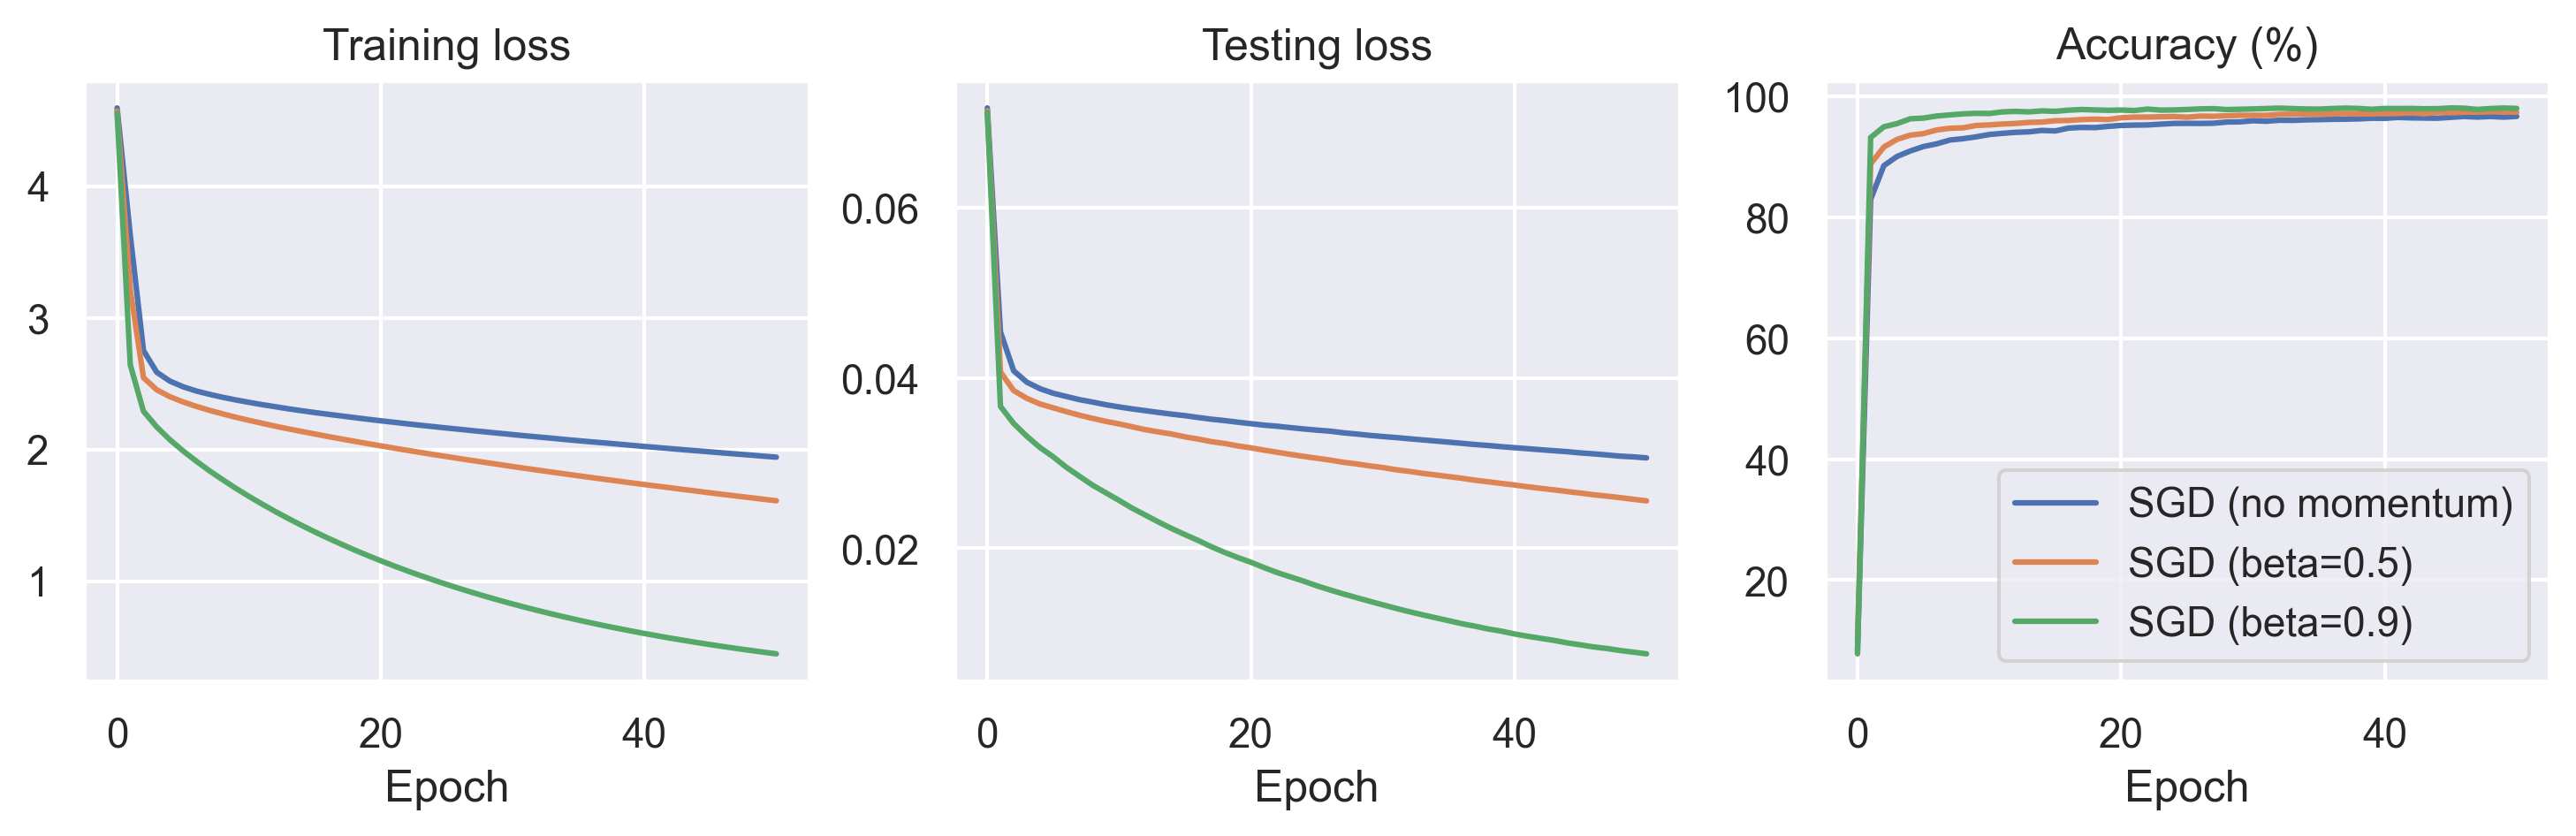

In [33]:
# auxiliary plotting function
def plot_results(training_losses_p_epoch, testing_losses_p_epoch, accuracies_p_epoch, legends):
    sns.set_theme()

    fig, ax = plt.subplots(1, 3)

    for i, training_loss_p_epoch in enumerate(training_losses_p_epoch):
        ax[0].plot(training_loss_p_epoch, label=legends[i])

    ax[0].set_title("Training loss")
    ax[0].set(xlabel="Epoch")

    for i, testing_loss_p_epoch in enumerate(testing_losses_p_epoch):
        ax[1].plot(testing_loss_p_epoch, label=legends[i])

    ax[1].set_title("Testing loss")
    ax[1].set(xlabel="Epoch")

    for i, accuracy_p_epoch in enumerate(accuracies_p_epoch):
        ax[2].plot(accuracy_p_epoch, label=legends[i])

    ax[2].set_title("Accuracy (%)")
    ax[2].set(xlabel="Epoch")

    plt.legend()
    plt.show()

plot_results(training_losses_p_epoch, testing_losses_p_epoch, accuracies_p_epoch, legends)

### Testing random samples of the test set

Next, we visualize the classification performance of the network on a random sample of the testing set.

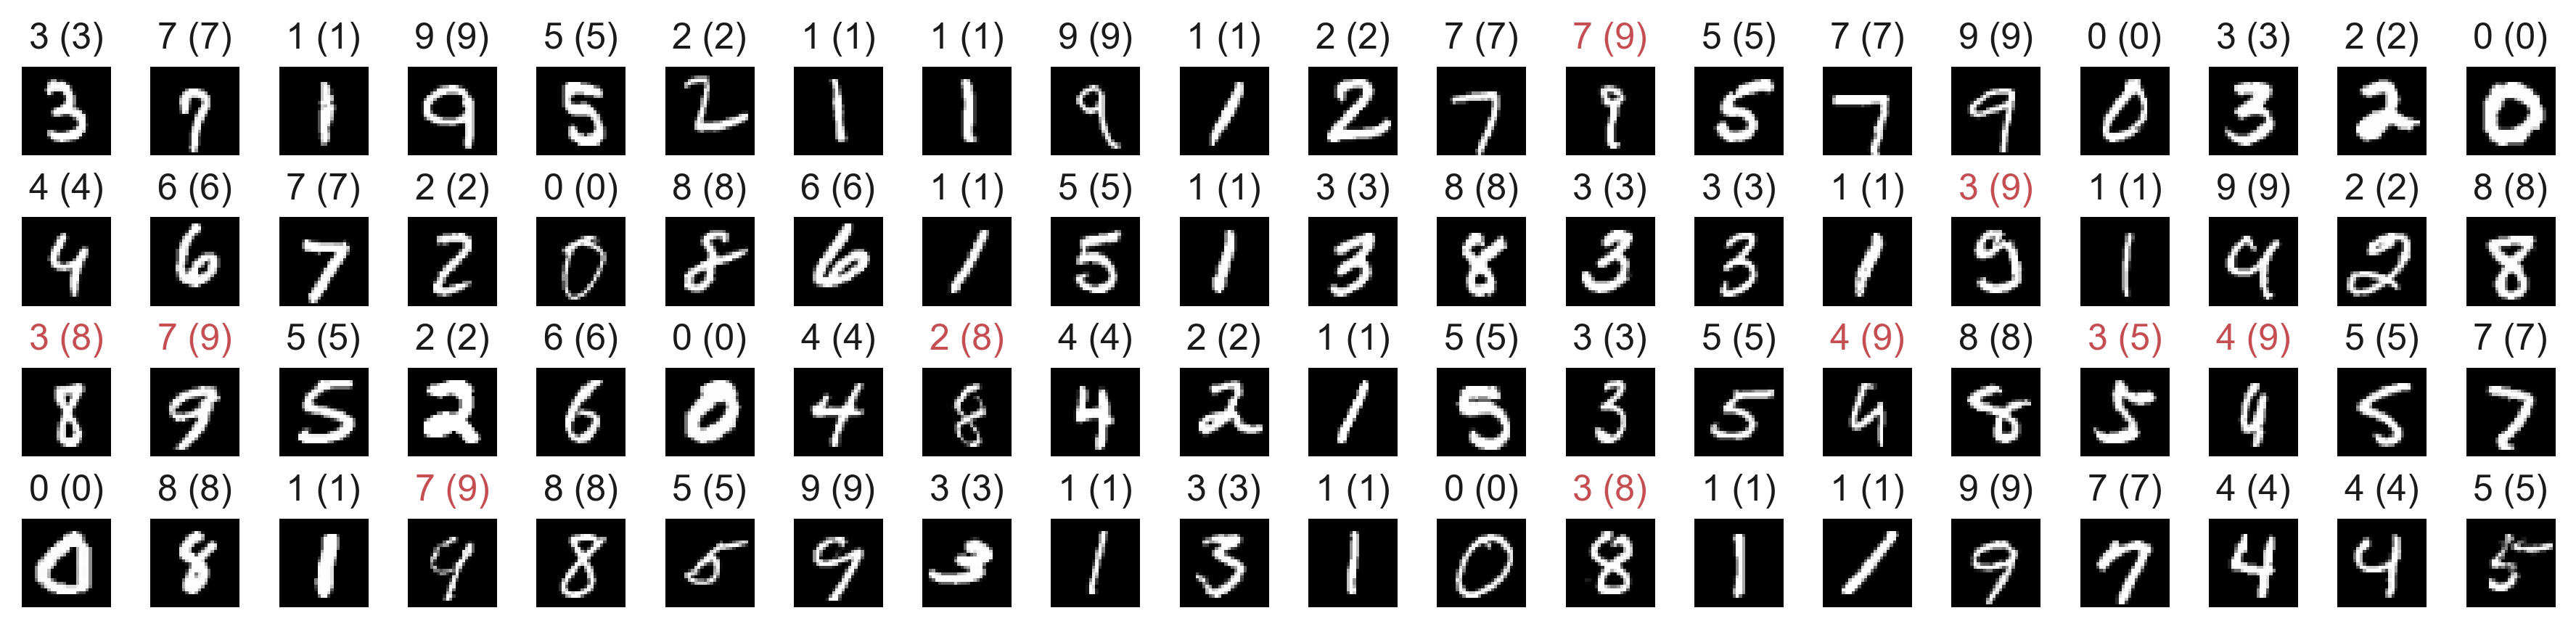

In [73]:
# query network at test set examples
n_rows = 4
n_columns = 20

indices = np.random.randint(len(test_loader.dataset.data), size=n_rows*n_columns)

fig, ax = plt.subplots(n_rows, n_columns)

with torch.no_grad():
    for i, (data, target) in enumerate(zip(test_loader.dataset.data[indices], test_loader.dataset.targets[indices])):
        output = int(networks[2](data.reshape(1, *data.shape)).argmax(dim=1)[0])

        l, m = i // n_columns, i % n_columns

        title_color = "k" if output == int(target) else "r"
        ax[l, m].imshow(data, cmap="gray")
        ax[l, m].set_title(f"{output} ({int(target)})", color=title_color)
        ax[l, m].set_axis_off()

plt.tight_layout()
plt.show()

### Distribution of classes and errors in the testing set

Here, we plot the distribution of classes predicted, the groundtruth one, and the pairwise error between the two. 

In [38]:
# comparison between network outputs and groundtruth target distribution
network_output_distribution = []
gt_output_distribution = []
with torch.no_grad():
    for data, target in test_loader:
        output = networks[2](data).argmax(dim=1)
        network_output_distribution.extend(output)
        gt_output_distribution.extend(target)

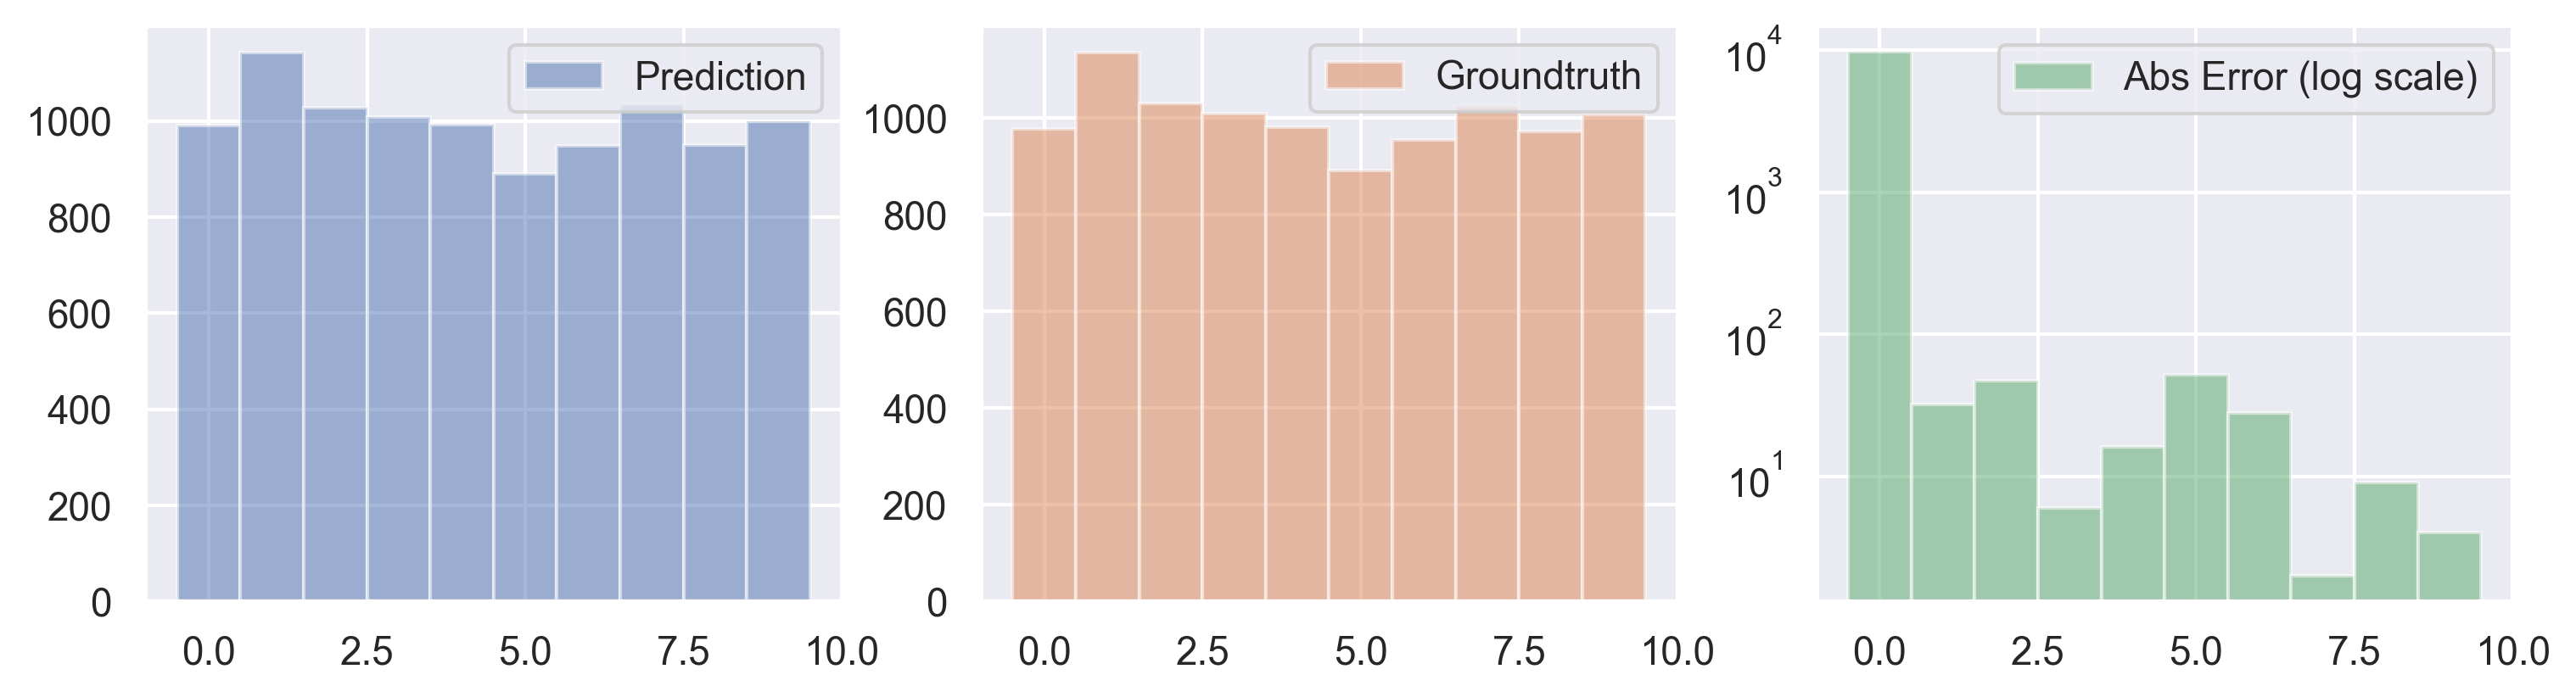

In [77]:
bins = [i-0.5 for i in range(0, 11)]

network_output_distribution_ = np.array([float(i) for i in network_output_distribution])
gt_output_distribution_ = np.array([float(i) for i in gt_output_distribution])

cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(1, 3)
ax[0].hist(network_output_distribution_, bins, alpha=0.5, label='Prediction', color=cmap[0])
ax[1].hist(gt_output_distribution_, bins, alpha=0.5, label='Groundtruth', color=cmap[1])
ax[2].hist(abs(gt_output_distribution_ - network_output_distribution_), bins, alpha=0.5, label='Abs Error (log scale)', color=cmap[2])
ax[2].set_yscale('log')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[2].legend(loc='upper right')
plt.show()

### Top-2 accuracy

We know the accuracy of network is 98%, but how does it perform in terms of top-2 accuracy, i.e. when we take as possible classes the 2 classes with the highest logits? This experiment calculates that value.

In [111]:
# calculate top-k accuracy for k=2
k = 2
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = networks[2](data)
        _, indices = output.topk(k, dim=1)
        correct += ((indices - target.reshape(-1, 1).repeat(1, k)).abs().min(dim=1).values == 0).sum()

top_k_accuracy = 100. * correct / len(test_loader.dataset)
print(float(top_k_accuracy))

99.23999786376953
